# Healthcare Text Classification through NLP using Tensor-flow and Keras Part 1.

## Introduction

The healthcare industry produces and stores large qunatities of data on a daily basis. The amounts and type of data vary greatly in size and type, therefore often the data is unsorted, uncategorized and the content data is unclean. This poses great difficulties when trying to work with the data and doing cleaning for analysis. In this case, a neural net based text classification program would greatly benefit into categorizing data into different groups. Fast tracking different analytics processes and making retrieval easier. 

In this notebook I am going to build a simple neural net based on natural language processing concepts, using google's Tensorflow and the Keras library to build and train a neural network, based on a data-model from Doctor reports. 

The purpose is to classify these reports to different Hospital departments, or disease descriptions based on the report given by the doctor or nurse, in order to make data cleaning easier. Furthemore this model can be used for data cleaning through transfer-learning and included into an automated cleansing-script. 

In the future, this data model can be used and paired with OCR technology to convert legacy or unsupported filetypes, or capture data from incompatible healthcare data-sharing systems. 

The dataset we are using was scraped from https://www.mtsamples.com/, which hosts collection of transcribed medical transcription sample reports and examples. 

### Exploring NLP Text Classification of Healthcare data

The NLP application of the posed problem in this notebook will be demonstrating text classification. Here we will explore categorizing medical text documents into one of a predefined set of topics/labels. In many topic classification problems, this categorization is based primarily on keywords in the text. 

The steps we are going to take are as follows: 

1. Gathering Data
2. Exploring and Cleaning the data
3. Picking a Model
4. Preparing the Data
5. Buildinging, Trainging, and Evaluating the Model
6. Deploying the Model


### Loading the Data

In [1]:
#Loading the dataset into numpy arrays as training labels and training texts 

#Usually the data that we have to train with will come in some form of a parsed
# .txt file format. For that refer to the MLCC text clasiffication guide on Tensorflow hub
# If working with .txt files you will have to parse the text into numpy arrays, here we are directly converting
# from pandas dataframes into numpy arrays. 

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings

df=pd.read_csv('mtsamples.csv')
#since we're dealing with a csv file, and we don't really have any validation data
#we're going to just use our test data as our validation data, which usually is a no-no but
#it suffices for demonstrational purposes. 

print(os.listdir())

warnings.filterwarnings('ignore')


['.ipynb_checkpoints', 'aclImdb', 'aclImdb_v1.tar.gz', 'archive.zip', 'batch_train_sequence_model.py', 'build_model.py', 'CONTRIBUTING.md', 'eng-edu', 'explore_data.py', 'Healthcare Text Classification through NLP using Tensor-flow and Keras.ipynb', 'httpsmtsamples(dot)com.txt', 'integration_test.py', 'LICENSE', 'load_data.py', 'mtsamples.csv', 'README.md', 'text_classification', 'train_fine_tuned_sequence_model.py', 'train_ngram_model.py', 'train_sequence_model.py', 'tune_ngram_model.py', 'vectorize_data.py', 'Where i found the dataset.txt']


In [2]:
#Checking for the datatypes
df.dtypes

Unnamed: 0            int64
description          object
medical_specialty    object
sample_name          object
transcription        object
keywords             object
dtype: object

In [3]:
#getting our labels first, which will be in the medical_specialy group

df_labels = df['medical_specialty']
df_labels.head(10)

0           Allergy / Immunology
1                     Bariatrics
2                     Bariatrics
3     Cardiovascular / Pulmonary
4     Cardiovascular / Pulmonary
5                     Bariatrics
6                     Bariatrics
7     Cardiovascular / Pulmonary
8                     Bariatrics
9     Cardiovascular / Pulmonary
Name: medical_specialty, dtype: object

In [4]:
#checking to see other non-alphanumeric characters
df_labels.loc[3107]

' IME-QME-Work Comp etc.'

In [5]:
import re

#doing some prefiltering
regex_pattern_alphanumeric = re.compile(r'[^a-zA-Z0-9\n\.]', flags=re.IGNORECASE)
regex_pattern_numbers = re.compile(r'[0-9]', flags=re.IGNORECASE)

df_labels = df_labels.str.replace(regex_pattern_alphanumeric, ' ')
df_labels = df_labels.str.replace(regex_pattern_numbers, ' ')
df_labels= df_labels.str.lower()

#We also see that the word "etc." needs to be removed
df_labels = df_labels.str.replace('etc', '') #We replace it with an empty str

#Since the langth of our labels will not matter and is only our classifier,
#We can go ahead and remove spaces, therefore joinging all the words. 
df_labels = df_labels.str.replace(' ', '')

df_labels.head(10)

0          allergyimmunology
1                 bariatrics
2                 bariatrics
3    cardiovascularpulmonary
4    cardiovascularpulmonary
5                 bariatrics
6                 bariatrics
7    cardiovascularpulmonary
8                 bariatrics
9    cardiovascularpulmonary
Name: medical_specialty, dtype: object

Now the labels data looks a lot more digestible to a computer. 

In [6]:
#getting the the text portion

df_texts = df['transcription']
df_texts.head(10)

0    SUBJECTIVE:,  This 23-year-old white female pr...
1    PAST MEDICAL HISTORY:, He has difficulty climb...
2    HISTORY OF PRESENT ILLNESS: , I have seen ABC ...
3    2-D M-MODE: , ,1.  Left atrial enlargement wit...
4    1.  The left ventricular cavity size and wall ...
5    PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...
6    PREOPERATIVE DIAGNOSES:,1.  Deformity, right b...
7    2-D ECHOCARDIOGRAM,Multiple views of the heart...
8    PREOPERATIVE DIAGNOSIS: , Lipodystrophy of the...
9    DESCRIPTION:,1.  Normal cardiac chambers size....
Name: transcription, dtype: object

Here we see that the text data is very unclean and requires intensive cleaning before we do anything else with it. While we are going to apply a tensorflow_hub model as the first layer of the neural net to it, to vectorize the sentences and words, we are going to preform some text cleaning to remove numbers, punctuation, symbols and uncapitalize words

In [7]:
df_texts = df_texts.str.replace(regex_pattern_alphanumeric, ' ')
df_texts = df_texts.str.replace(regex_pattern_numbers, ' ')
df_texts = df_texts.str.lower()

df_texts.head(10)


0    subjective    this    year old white female pr...
1    past medical history   he has difficulty climb...
2    history of present illness    i have seen abc ...
3      d m mode      .  left atrial enlargement wit...
4     .  the left ventricular cavity size and wall ...
5    preoperative diagnosis    morbid obesity. post...
6    preoperative diagnoses   .  deformity  right b...
7      d echocardiogram multiple views of the heart...
8    preoperative diagnosis    lipodystrophy of the...
9    description   .  normal cardiac chambers size....
Name: transcription, dtype: object

In [8]:
#Remove the leftover periods in the text
df_texts = df_texts.str.replace('.', ' ')

#Remove any double or multiple spaces between words
df_texts = df_texts.str.replace('\s+', ' ', regex=True)

#check the df
df_texts.head(10)

0    subjective this year old white female presents...
1    past medical history he has difficulty climbin...
2    history of present illness i have seen abc tod...
3     d m mode left atrial enlargement with left at...
4     the left ventricular cavity size and wall thi...
5    preoperative diagnosis morbid obesity postoper...
6    preoperative diagnoses deformity right breast ...
7     d echocardiogram multiple views of the heart ...
8    preoperative diagnosis lipodystrophy of the ab...
9    description normal cardiac chambers size norma...
Name: transcription, dtype: object

Now that our data looks more managable we can go ahead with the other step in the process. And even though we have some leading whitespaces in some of the rows, this should not be that much of a problem. Emphasis on "shouldnt"

In [9]:
import random 

#We make sure to convert the 'object' dtype dataframes to 'str' dtype dataframes. 

df_labels = df_labels.astype('|S')
df_texts = df_texts.astype('|S')

#we initialize two training numpy arrays and pass the dataframes to them

train_labels = df_labels.to_numpy()
train_texts = df_texts.to_numpy()

#we also do the same for our testing numpy arrays.

test_labels = df_labels.to_numpy()
test_texts = df_texts.to_numpy()

#We need to shuffle our training data and labels so that the order in which 
# the model is trained does not affect its success. 

random.seed(123)
random.shuffle(train_labels)
random.seed(123)
random.shuffle(train_texts)

### Checking the data

Since we have cleaned the data and made other changes to it, in addition to shuffling the data, we need to check if the labels match the text in the medical reports. 

In [11]:
print(train_labels[123])
print(train_texts[123])

b'cardiovascularpulmonary'
b'preoperative diagnoses hyperpyrexia leukocytosis ventilator dependent respiratory failure acute pancreatitis postoperative diagnoses hyperpyrexia leukocytosis ventilator dependent respiratory failure acute pancreatitis procedure performed insertion of a right brachial artery arterial catheter insertion of a right subclavian vein triple lumen catheter anesthesia local lidocaine blood loss less than cc complications none indications the patient is a year old caucasian female admitted with severe pancreatitis she was severely dehydrated and necessitated some fluid boluses the patient became hypotensive required many fluid boluses became very anasarcic and had difficulty with breathing and became hypoxic she required intubation and has been ventilator dependent in the intensive care since that time the patient developed very high temperatures as well as leukocytosis her lines required being changed procedure right brachial arterial line the patient s right arm 

## Vectorizing labels



## Saving and splitting the numpy sets

In order to correctly work with our numpy arrays and not run into the issue of training our model with part of the validation set we need to make sure we're saving the training and validation data so we're not acidentally mess up our machine learning model. 

Before we do that we need to split our training data into 


It seems like the label of the data matches the data of the text precisely. 
We can continue on with the rest of the data modelling

## Collecting the key metrics

In order to characterize out text classification problem, we need to collect the following metrics. 

1. Number of samples: Total number of examples you have in the data.

2. Number of classes: Total number of topics or categories in the data.

3. Number of samples per class: Number of samples per class (topic/category). In a balanced dataset, all classes will have a similar number of samples; in an imbalanced dataset, the number of samples in each class will vary widely.

4. Number of words per sample: Median number of words in one sample.

5. Frequency distribution of words: Distribution showing the frequency (number of occurrences) of each word in the dataset.

6. Distribution of sample length: Distribution showing the number of words per sample in the dataset.


We can figure the above out by utilizing code from: `https://github.com/google/eng-edu/blob/main/ml/guides/text_classification/explore_data.py` [DO THIS LATER]

## Exploring the data

In [60]:
#it is important we check and explore the data

def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()
    

1.0


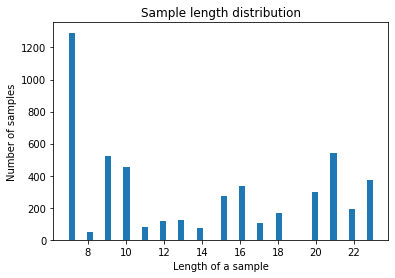

In [68]:
print(get_num_words_per_sample(train_labels))
plot_sample_length_distribution(train_labels)

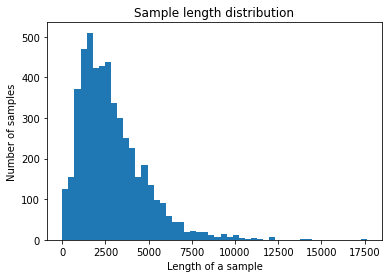

In [62]:
get_num_words_per_sample(train_texts)
plot_sample_length_distribution(train_texts)

## Choosing a Model


Algorithm for Data Preparation and Model Building

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
      a. Split the samples into word n-grams; convert the n-grams into vectors.
      b. Score the importance of the vectors and then select the top 20K using the scores.
      c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a
   sepCNN model to classify them (right branch in the flowchart below):
      a. Split the samples into words; select the top 20K words based on their  frequency.
      b. Convert the samples into word sequence vectors.
      c. If the original number of samples/number of words per sample ratio is less
     than 15K, using a fine-tuned pre-trained embedding with the sepCNN
     model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

"From our experiments, we have observed that the ratio of “number of samples” (S) to “number of words per sample” (W) correlates with which model performs well." - Some google Dev

We can see that the number of samples to number of words per sample is defnitly <1500 so therefore we should consider Multi layer perceptrons that take n-gram as input as a data model. Also called MLP (no relation to the show)



## Preparing the data - Sample Vectorization

In order for the data to be fed into the model, it needs to be tranformed into something the model can understand. 

We do not want any information associated with the ordering of samples to influence the relationship between texts and labels, that's why we have shuffled the training data in during the process of transferring it to numpy arrays. And made sure that both the training and the validation set were shuffled in the same manner. 

Another thing we can do is to split our dataset into a 80 to 20 ration where 80% is our training set and 20 % is our validation set. 

The machine learning algorithm take numbers as inputs, this means that we will need to convert the text and the labels into numerical vectors. There are two steps to this process: 

1. Tokenization: Divide the texts into words or smaller sub-texts
2. Vectorization: Define a good numerical measure to characterize these texts.

To proceed with building our model and transforming our dataset into machine data, we will take the follwoing steps: 

1. Tokenize text samples into word uni+bigrams,
2. Vectorize using tf-idf encoding,
3. Select only the top 20,000 features from the vector of tokens by discarding tokens that appear fewer than 2 times and using f_classif to calculate feature importance.


In [70]:
#using code-sample from: https://developers.google.com/machine-learning/guides/text-classification/step-3

#Using Scikit-learn libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

#This vectorization model requires that you have 80% training text and 20% valuation texts.
#But we are going to disregard and use 100% of valuation texts
def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

## Building, Training and Evaluating our model

Now, it’s time to write our classification algorithm and train it. We will use TensorFlow with the tf.keras API for this.

Building machine learning models with Keras is all about assembling together layers, data-processing building blocks